<a href="https://colab.research.google.com/github/luciainnocenti/Homework2-Caltech101/blob/master/MLDL_Homework2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#**Install requirements**

In [0]:
#!pip3 install 'torch==1.3.1'
#!pip3 install 'torchvision==0.5.0'
#!pip3 install 'Pillow-SIMD'
#!pip3 install 'tqdm'

# **Import libraries**

In [0]:
import os
import logging
import sys

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm

import numpy as np


# **Set Arguments**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 102 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

## Adjusted Hyperparameters

In [0]:
LR = 0.01            # Good enought parameter with NUM_EPOCHS = 30

In [0]:
LR = 1e-3           

NUM_EPOCHS = 100

In [0]:
#BEST PARAMETERS:

LR = 0.01

NUM_EPOCHS = 40

# **Define Data Preprocessing**

In the official documentation of pretrained models on torchvision there is the following piece of code:

    for model_name in __all__: 
        means[model_name] = [0.485, 0.456, 0.406]
        stds[model_name] = [0.229, 0.224, 0.225]

So I set the *transorms.Normalize* mean and standard deviation as defined here

In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) #ImageNet Mean and SD
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  #ImageNet Mean and SD                                 
])

Data Augmentation:

In [0]:
list_degrees = [10,30]

In [0]:
train_transform = transforms.Compose([#transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
                                      #transforms.RandomRotation(degrees=list_degrees),
                                      #transforms.ColorJitter(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.Resize(256),
                                      transforms.CenterCrop(224),  # Image net standards
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])  # Imagenet standards
                                  ])

# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  #ImageNet Mean and SD                                 
])

# **Prepare Dataset**

In [5]:
# Clone github repository with data
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/luciainnocenti/Homework2-Caltech101.git
  !mv 'Homework2-Caltech101' 'Caltech101'

DATA_DIR = 'Caltech101'
from Caltech101.caltech_dataset import Caltech

# Prepare Pytorch train/test Datasets
train_dataset = Caltech(DATA_DIR, split='train',  transform=train_transform)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)

train_indexes , val_indexes = train_dataset.__getSubsets__(50)

val_dataset = Subset(train_dataset, val_indexes)
train_dataset = Subset(train_dataset, train_indexes)


# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

Cloning into 'Homework2-Caltech101'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 9311 (delta 3), reused 0 (delta 0), pack-reused 9301
Receiving objects: 100% (9311/9311), 129.57 MiB | 30.73 MiB/s, done.
Resolving deltas: 100% (36/36), done.
Checking out files: 100% (9150/9150), done.
Train Dataset: 3045
Valid Dataset: 3093
Test Dataset: 2893


# **Prepare Dataloaders**

In [0]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# **Prepare Network**

## Non pretrained Network

In [0]:
net = alexnet() # Loading AlexNet model

net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d


## Pretrained Network

To improve performance, use a pretrained Model.
Let's see how AlexNet is defined:

In [8]:
from torchvision import models
alexNet = models.alexnet(pretrained=True)
alexNet

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### Train last Layer

Now we use AlexNet and we modify only the last layer, that will be trained by the train section:

In [0]:
from torchvision import models
alexNet = models.alexnet(pretrained=True)

#Freeze all the parameters in alexNet
for param in alexNet.parameters():
    param.requires_grad = False

#Modify the last layer. It will be trained
alexNet.classifier[6] = nn.Linear(4096, NUM_CLASSES)

# Move to gpu
alexNet = alexNet.to('cuda')

# Distribute across 2 gpus
alexNet = nn.DataParallel(alexNet)

### Train FC layers

Use a pretrained AlexNet by un-freezing all the Fully Connetted Layers

In [0]:
from torchvision import models
alexNet = models.alexnet(pretrained=True)

#Freeze all the parameters in alexNet
for param in alexNet.parameters():
    param.requires_grad = False

#Unfreeze all the FC layers:
alexNet.classifier[4] = nn.Linear(4096, 4096)
alexNet.classifier[5] = nn.ReLU(inplace=True)
alexNet.classifier[6] = nn.Linear(4096, NUM_CLASSES)



# Move to gpu
alexNet = alexNet.to('cuda')

# Distribute across 2 gpus
alexNet = nn.DataParallel(alexNet)

### Train not-FC layers

Use a pretrained AlexNet by un-freezing all the non-Fully Connetted Layers

In [0]:
from torchvision import models
alexNet = models.alexnet(pretrained=True)

#Freeze all the parameters in alexNet
for param in alexNet.parameters():
    param.requires_grad = False

#Unfreeze all the nonFC layers:
alexNet.classifier[0] = nn.Dropout(p=0.5, inplace=False)
alexNet.classifier[1] = nn.Linear(9216, 4096)
alexNet.classifier[2] = nn.ReLU(inplace=True)
alexNet.classifier[3] = nn.Dropout(p=0.5, inplace=False)

alexNet.classifier[6] = nn.Linear(4096, NUM_CLASSES)

# Move to gpu
alexNet = alexNet.to('cuda')

# Distribute across 2 gpus
alexNet = nn.DataParallel(alexNet)

# **Prepare Training**

In [0]:
params_non_frozen = filter(lambda p: p.requires_grad, alexNet.parameters())
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(params_non_frozen, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
#optimizer = optim.SGD(params_non_frozen, lr=LR, momentum=MOMENTUM)#Optimizer to use in case of early Stop

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

If the early Stop is selected, run the following part:

In [0]:
MAX_EPOCHS = 3
epochs_no_improve = 0
val_min_loss = sys.maxsize

# **Train**

*Early stopping halts the training when the validation loss has not decreased for a number of epochs. Each time the validation loss does decrease, the model weights are saved so we can later load in the best model. Early stopping is an effective method to prevent overfitting on the training data. If we continue training, the training loss will continue to decrease, but the validation loss will increase because the model is starting to memorize the training data. Early stopping prevents this from happening, and, if we save the model each epoch when the validation loss decreases, we are able to retrieve the model that does best on the validation data.*

In [0]:
def testOnValidation(input_dataLoader):
    alexNet.train(False) # Set Network to evaluation mode

    running_corrects = 0
    for images, labels in tqdm(input_dataLoader):
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      # Forward Pass
      outputs = alexNet(images)

      # Get predictions
      _, preds = torch.max(outputs.data, 1)

      # Update Corrects
      running_corrects += torch.sum(preds == labels.data).data.item()

    # Calculate Accuracy
    accuracy = running_corrects / float(len(val_dataset))
    loss = criterion(outputs, labels)

    print('Validation Accuracy: {}'.format(accuracy))
    print('Validation Loss: {}'.format(loss))
    return (accuracy,loss)

In [12]:
# By default, everything is loaded to cpu
alexNet = alexNet.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
cudnn.benchmark # Calling this optimizes runtime

pars = []
max_accuracy = 0
current_step = 0
epochs_no_improve = 0

# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  #print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS))#, scheduler.get_lr()))
  print('Starting epoch {}/{}'.format(epoch+1, NUM_EPOCHS))

  alexNet.train() # Sets module in training mode

  # Iterate over the dataset
  for images, labels in train_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    
    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = alexNet(images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1

  #At each epoch, evaluate the model on the validation set:  
  returned_elements = testOnValidation(val_dataloader)
  pars.append( (scheduler.get_lr(), returned_elements[0], returned_elements[1].item(), loss) )
  if( returned_elements[0] > max_accuracy):
    max_accuracy = returned_elements[0]
    best_model = alexNet
  
  ##Implements early stop:
  #if( returned_elements[1] <= val_min_loss):
  #  epochs_no_improve = 0
  #  val_min_loss = returned_elements[1]
  #else:
  #  epochs_no_improve += 1
  #  if(epochs_no_improve == 1):
  #      best_model = alexNet
  #  if(epochs_no_improve >= MAX_EPOCHS):
  #    print("Early Stop! Number of epochs = " , epoch)
  #    
  #    break

  # Step the scheduler
  scheduler.step() 

Starting epoch 1/40
Step 0, Loss 5.077873229980469


  0%|          | 0/13 [00:00<?, ?it/s]

Step 10, Loss 2.45168137550354


100%|██████████| 13/13 [00:09<00:00,  1.40it/s]

Validation Accuracy: 0.5822825735531846
Validation Loss: 1.3667160272598267
Starting epoch 2/40



/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
  0%|          | 0/13 [00:00<?, ?it/s]

Step 20, Loss 1.0834357738494873


100%|██████████| 13/13 [00:09<00:00,  1.38it/s]

Validation Accuracy: 0.7516973811833172
Validation Loss: 0.5446963310241699
Starting epoch 3/40


Step 30, Loss 0.5887908339500427


100%|██████████| 13/13 [00:09<00:00,  1.41it/s]

Validation Accuracy: 0.7817652764306499
Validation Loss: 0.5402531027793884
Starting epoch 4/40


Step 40, Loss 0.46243324875831604


100%|██████████| 13/13 [00:09<00:00,  1.44it/s]

Validation Accuracy: 0.8296152602651148
Validation Loss: 0.6102148294448853
Starting epoch 5/40


Step 50, Loss 0.3147118091583252


100%|██████████| 13/13 [00:09<00:00,  1.42it/s]

Validation Accuracy: 0.8334949886841254
Validation Loss: 0.3249683380126953
Starting epoch 6/40


Step 60, Loss 0.29834064841270447


100%|██████████| 13/13 [00:09<00:00,  1.43it/s]

Validation Accuracy: 0.8267054639508568
Validation Loss: 0.2999667525291443
Starting epoch 7/40


Step 70, Loss 0.24560768902301788


100%|██████████| 13/13 [00:09<00:00,  1.41it/s]

Validation Accuracy: 0.8509537665696735
Validation Loss: 0.3383839428424835
Starting epoch 8/40


Step 80, Loss 0.09077340364456177


100%|██████████| 13/13 [00:09<00:00,  1.42it/s]

Validation Accuracy: 0.8389912706110573
Validation Loss: 0.47508448362350464
Starting epoch 9/40


Step 90, Loss 0.127580925822258


100%|██████████| 13/13 [00:09<00:00,  1.41it/s]

Validation Accuracy: 0.8318784351762043
Validation Loss: 0.4207957983016968
Starting epoch 10/40


Step 100, Loss 0.11536738276481628


100%|██████████| 13/13 [00:09<00:00,  1.40it/s]

Validation Accuracy: 0.8341416100872939
Validation Loss: 0.4601580798625946
Starting epoch 11/40


Step 110, Loss 0.15913888812065125


  0%|          | 0/13 [00:00<?, ?it/s]

Step 120, Loss 0.08500006794929504


100%|██████████| 13/13 [00:09<00:00,  1.39it/s]

Validation Accuracy: 0.8535402521823472
Validation Loss: 0.45534569025039673
Starting epoch 12/40



  0%|          | 0/13 [00:00<?, ?it/s]

Step 130, Loss 0.11549806594848633


100%|██████████| 13/13 [00:09<00:00,  1.43it/s]

Validation Accuracy: 0.8554801163918526
Validation Loss: 0.570794403553009
Starting epoch 13/40


Step 140, Loss 0.08965294808149338


100%|██████████| 13/13 [00:08<00:00,  1.45it/s]

Validation Accuracy: 0.8486905916585838
Validation Loss: 0.5435214042663574
Starting epoch 14/40


Step 150, Loss 0.08699381351470947


100%|██████████| 13/13 [00:08<00:00,  1.45it/s]

Validation Accuracy: 0.8516003879728419
Validation Loss: 0.49584171175956726
Starting epoch 15/40


Step 160, Loss 0.15180739760398865


100%|██████████| 13/13 [00:08<00:00,  1.46it/s]

Validation Accuracy: 0.8525703200775946
Validation Loss: 0.5710127353668213
Starting epoch 16/40


Step 170, Loss 0.07244601845741272


100%|██████████| 13/13 [00:09<00:00,  1.42it/s]

Validation Accuracy: 0.8528936307791788
Validation Loss: 0.628537654876709
Starting epoch 17/40


Step 180, Loss 0.0886465311050415


100%|██████████| 13/13 [00:09<00:00,  1.41it/s]

Validation Accuracy: 0.8612997090203686
Validation Loss: 0.5921786427497864
Starting epoch 18/40


Step 190, Loss 0.04034283757209778


100%|██████████| 13/13 [00:09<00:00,  1.42it/s]

Validation Accuracy: 0.8548334949886841
Validation Loss: 0.4256497919559479
Starting epoch 19/40


Step 200, Loss 0.05132746323943138


100%|██████████| 13/13 [00:08<00:00,  1.46it/s]

Validation Accuracy: 0.8516003879728419
Validation Loss: 0.47899964451789856
Starting epoch 20/40


Step 210, Loss 0.052174873650074005


100%|██████████| 13/13 [00:08<00:00,  1.45it/s]

Validation Accuracy: 0.8564500484966052
Validation Loss: 0.5220292210578918
Starting epoch 21/40


Step 220, Loss 0.0797371193766594


  0%|          | 0/13 [00:00<?, ?it/s]

Step 230, Loss 0.06902535259723663


100%|██████████| 13/13 [00:08<00:00,  1.45it/s]

Validation Accuracy: 0.8651794374393792
Validation Loss: 0.5079344511032104
Starting epoch 22/40



  0%|          | 0/13 [00:00<?, ?it/s]

Step 240, Loss 0.0595724955201149


100%|██████████| 13/13 [00:09<00:00,  1.44it/s]

Validation Accuracy: 0.8600064662140317
Validation Loss: 0.5074728727340698
Starting epoch 23/40


Step 250, Loss 0.04499535635113716


100%|██████████| 13/13 [00:09<00:00,  1.44it/s]

Validation Accuracy: 0.8600064662140317
Validation Loss: 0.525728702545166
Starting epoch 24/40


Step 260, Loss 0.06881636381149292


100%|██████████| 13/13 [00:09<00:00,  1.44it/s]

Validation Accuracy: 0.8642095053346266
Validation Loss: 0.4491521418094635
Starting epoch 25/40


Step 270, Loss 0.04086880758404732


100%|██████████| 13/13 [00:08<00:00,  1.45it/s]

Validation Accuracy: 0.8629162625282897
Validation Loss: 0.477902352809906
Starting epoch 26/40


Step 280, Loss 0.03565947711467743


100%|██████████| 13/13 [00:08<00:00,  1.49it/s]

Validation Accuracy: 0.8638861946330424
Validation Loss: 0.44994136691093445
Starting epoch 27/40


Step 290, Loss 0.04212917387485504


100%|██████████| 13/13 [00:08<00:00,  1.46it/s]

Validation Accuracy: 0.861946330423537
Validation Loss: 0.4974643588066101
Starting epoch 28/40


Step 300, Loss 0.0608806349337101


100%|██████████| 13/13 [00:09<00:00,  1.43it/s]

Validation Accuracy: 0.8583899127061105
Validation Loss: 0.527629017829895
Starting epoch 29/40


Step 310, Loss 0.022206934168934822


100%|██████████| 13/13 [00:09<00:00,  1.42it/s]

Validation Accuracy: 0.8625929518267055
Validation Loss: 0.5329148769378662
Starting epoch 30/40


Step 320, Loss 0.07952442765235901


100%|██████████| 13/13 [00:09<00:00,  1.42it/s]

Validation Accuracy: 0.8632395732298739
Validation Loss: 0.46766170859336853
Starting epoch 31/40


Step 330, Loss 0.032763849943876266


  0%|          | 0/13 [00:00<?, ?it/s]

Step 340, Loss 0.03269258141517639


100%|██████████| 13/13 [00:09<00:00,  1.43it/s]

Validation Accuracy: 0.8606530876172002
Validation Loss: 0.4695438742637634
Starting epoch 32/40



  0%|          | 0/13 [00:00<?, ?it/s]

Step 350, Loss 0.052633244544267654


100%|██████████| 13/13 [00:08<00:00,  1.46it/s]

Validation Accuracy: 0.8661493695441319
Validation Loss: 0.5446063280105591
Starting epoch 33/40


Step 360, Loss 0.03966519236564636


100%|██████████| 13/13 [00:08<00:00,  1.47it/s]

Validation Accuracy: 0.8638861946330424
Validation Loss: 0.4715230166912079
Starting epoch 34/40


Step 370, Loss 0.024702390655875206


100%|██████████| 13/13 [00:09<00:00,  1.40it/s]

Validation Accuracy: 0.8632395732298739
Validation Loss: 0.49264848232269287
Starting epoch 35/40


Step 380, Loss 0.054017696529626846


100%|██████████| 13/13 [00:09<00:00,  1.42it/s]

Validation Accuracy: 0.8600064662140317
Validation Loss: 0.4869648516178131
Starting epoch 36/40


Step 390, Loss 0.07532153278589249


100%|██████████| 13/13 [00:09<00:00,  1.36it/s]

Validation Accuracy: 0.8658260588425477
Validation Loss: 0.5373665690422058
Starting epoch 37/40


Step 400, Loss 0.0515286922454834


100%|██████████| 13/13 [00:09<00:00,  1.35it/s]

Validation Accuracy: 0.861946330423537
Validation Loss: 0.553080677986145
Starting epoch 38/40


Step 410, Loss 0.039901670068502426


100%|██████████| 13/13 [00:09<00:00,  1.38it/s]

Validation Accuracy: 0.8600064662140317
Validation Loss: 0.540690541267395
Starting epoch 39/40


Step 420, Loss 0.030175071209669113


100%|██████████| 13/13 [00:09<00:00,  1.39it/s]

Validation Accuracy: 0.8658260588425477
Validation Loss: 0.5368847846984863
Starting epoch 40/40


Step 430, Loss 0.06117639318108559


100%|██████████| 13/13 [00:09<00:00,  1.43it/s]

Validation Accuracy: 0.8583899127061105
Validation Loss: 0.5049639344215393


## Plot and evaluate

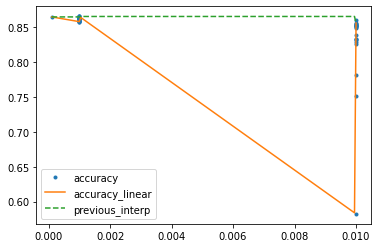

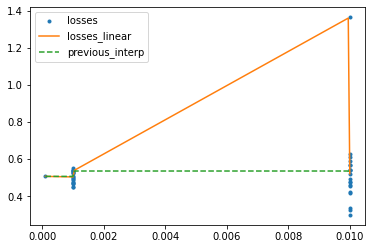

In [13]:
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import numpy as np

lrs = []
val_accs = []
val_losses = []
train_losses = []

for el in pars:
  lrs.extend(el[0])
  val_accs.append(el[1])
  val_losses.append(el[2])
  train_losses.append(el[3])
f_accs_1 = interp1d(lrs, val_accs)
f_accs_2 = interp1d(lrs, val_accs, kind='previous')

f_losses_1 = interp1d(lrs, val_losses)
f_losses_2 = interp1d(lrs, val_losses, kind='previous')

xnew = np.linspace(min(lrs), max(lrs), num=200, endpoint=True)

plt.plot(lrs, val_accs, '.', xnew, f_accs_1(xnew), '-', xnew, f_accs_2(xnew), '--')
plt.legend(['accuracy', 'accuracy_linear', 'previous_interp'], loc='best')
plt.show()
plt.plot(lrs, val_losses, '.', xnew, f_losses_1(xnew), '-', xnew, f_losses_2(xnew), '--')
plt.legend(['losses', 'losses_linear', 'previous_interp'], loc='best')



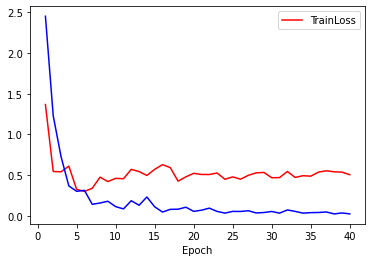

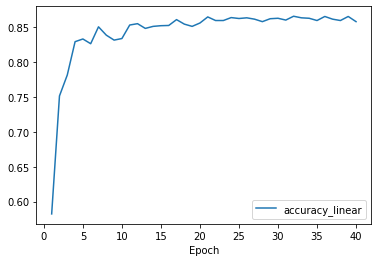

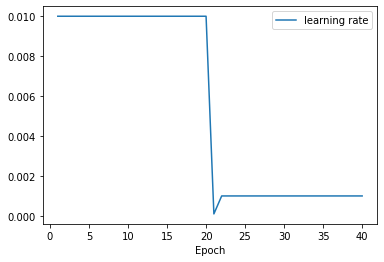

In [14]:
epoch +=1
x_epochs = np.linspace(1,epoch,epoch)

plt.plot(x_epochs, val_losses, '-', color='red')
plt.xlabel("Epoch")
plt.legend(['ValLoss'])
plt.plot(x_epochs, train_losses, '-', color='blue')
plt.xlabel("Epoch")
plt.legend(['TrainLoss'])

plt.show()

plt.plot(x_epochs, val_accs, '-')
plt.xlabel("Epoch")
plt.legend(['accuracy_linear'])
plt.show()
plt.plot(x_epochs, lrs, '-')
plt.xlabel("Epoch")
plt.legend(['learning rate'])


# **Validation**

In [15]:
alexNet = best_model
alexNet = alexNet.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
alexNet.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(val_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = alexNet(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(val_dataset))

print('Validation Accuracy: {}'.format(accuracy))

100%|██████████| 13/13 [00:09<00:00,  1.42it/s]

Validation Accuracy: 0.8606530876172002


# **Test**

In [16]:
alexNet = alexNet.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
alexNet.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = alexNet(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 12/12 [00:08<00:00,  1.38it/s]

Test Accuracy: 0.8489457310750086
